
# **Brain Tumor Detection from MRI scans**

**Name:** Yujin Jeon  
**Matriculation No:** 38933788  
**Course:** Software Engineering, M.Sc.  
**University:** University of Europe for Applied Sciences


---

## 1. Topic Overview  
Detecting brain tumors using various deep learning models based on MRI scan data.

---

## 2. Models Used

| Model            | Type        | Description                                  |
|------------------|-------------|----------------------------------------------|
| 1. CNN           | Baseline    | Simple Convolutional Neural Network          |
| 2. XceptionNet   | Heavy CNN   | Deep CNN with depthwise separable convolutions |
| 3. EfficientNet-B0 | Light CNN | Lightweight and efficient CNN architecture   |
| 4. ViT           | Transformer | Vision Transformer using self-attention      |

---

## 3. Development Environment

- **Platform**: Kaggle (training & evaluation & visualization), Google Colab (visualization)
- **Hardware**: Dual NVIDIA T4 GPUs (T4x2)  
- **Framework**: PyTorch
- **Frontend**: Streamlit

---

## 4. Dataset

- **Source**: [Kaggle - Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)  
- **Data Split**:
  - Train: 5,521 images (82.1%)  
  - Test: 1,205 images (17.9%)  
  - **Total**: 6,726 MRI scans  

---

## 5. Research Questions

> ### RQ1: Model Performance
*How do the ViT, XceptionNet, EfficientNet-B0, and a basic CNN differ in terms of accuracy, precision, recall, and other key performance metrics when detecting brain tumors from MRI images?*

> ### RQ2: Model Complexity & Architecture
*How does model complexity (such as number of parameters and computational cost) or architectural choice (CNN vs. Transformer) influence the performance and efficiency of these models in brain tumor detection?*

> ### RQ3: Error Analysis  
*Which tumor types are most frequently misclassified by each model, and what patterns or trends can be observed from the confusion matrices and class-wise metrics?*

> ### RQ4: Training Dynamics
*How does the accuracy of the basic CNN model change as the number of training epochs increases (in steps of 10 up to 100), and what can we learn from this trend about the training needs of a simple CNN for brain tumor detection?*

> ### RQ5: eXplainable AI (Grad-CAM Visualization)
*What insights can be gained from Grad-CAM visualizations about the decision-making process of each CNN-based model for brain tumor detection?*

---

## 🧠 **[Try the Brain Tumor Detection Demo](https://braintumorclassification-ofjem34wtqqbrwbrxsgggj.streamlit.app/)**
Test the frontend directly with sample MRI images and explore model predictions and Grad-CAM visualizations.


# 1. Install Packages

In [ ]:
# For EfficientNet
!pip install efficientnet_pytorch

# For XceptionNet
!pip install timm

# For grad-CAM
!pip install torch torchvision matplotlib numpy
!pip install grad-cam

# For getting params from each model
!pip install ptflops

!pip install pdf2image

# 2. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import os
import shutil
import random
import time
import seaborn as sns
import numpy as np
import cv2
import pandas as pd
import json
import joblib
import hashlib

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from efficientnet_pytorch import EfficientNet
from glob import glob
from sklearn.metrics import ( classification_report, precision_score
                            , recall_score, f1_score, roc_auc_score
                            , confusion_matrix, accuracy_score, roc_curve, auc )
from sklearn.preprocessing import label_binarize
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAMPlusPlus
from pathlib import Path
from IPython.display import display
from pdf2image import convert_from_path
from ptflops import get_model_complexity_info



# 3-1. Dataset Duplicate Check

In [ ]:
# Number of duplicates : 297 -> 0
labels = ["glioma", "meningioma", "notumor", "pituitary"]
data_dir = Path('/kaggle/input/dupl-remove/Dataset')

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in labels:
            folder_path = os.path.join(data_dir, data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]

def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                # os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")

if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)


Number of duplicates : 0


# 3-2. Dataset Preview

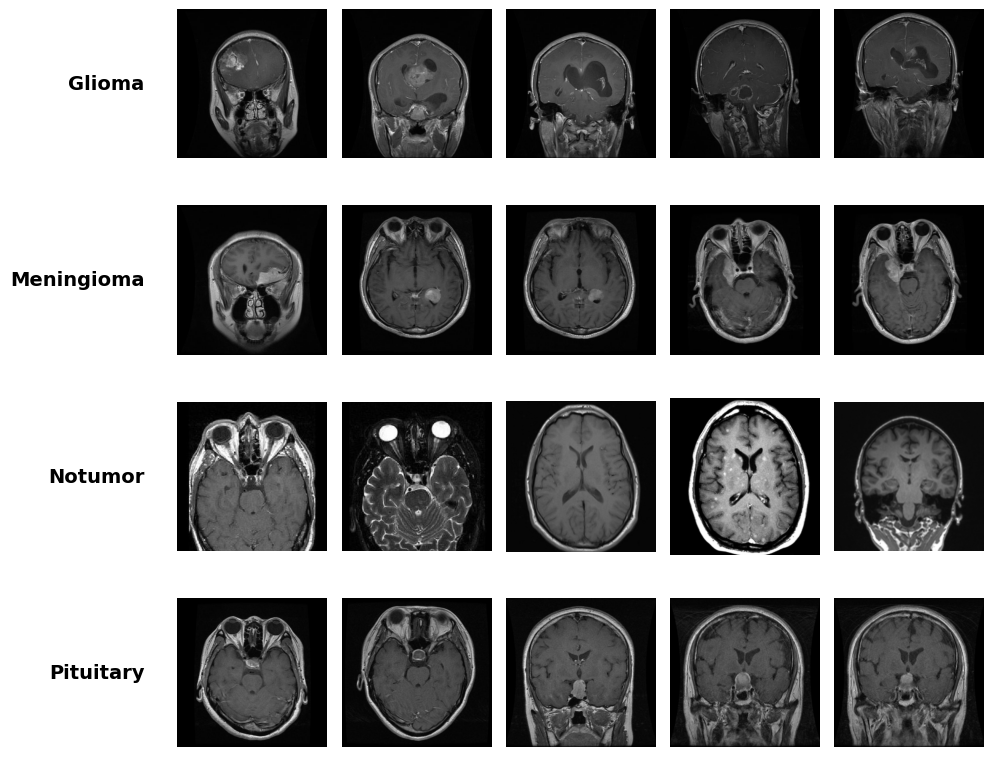

In [ ]:

# dir
dataset_dir = "/kaggle/input/dupl-remove/Dataset/Training"
class_names = ["glioma", "meningioma", "notumor", "pituitary"]
imgs_per_class = 5  # image number by class

# get image path
all_imgs = []
for cls in class_names:
    class_dir = os.path.join(dataset_dir, cls)
    img_files = [f for f in os.listdir(class_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    img_files = sorted(img_files)[:imgs_per_class]
    all_imgs.append([os.path.join(class_dir, f) for f in img_files])

fig, axes = plt.subplots(len(class_names), imgs_per_class, figsize=(imgs_per_class*2, len(class_names)*2))

for i, cls in enumerate(class_names):          # i: 4 class
    for j in range(imgs_per_class):            # j: column
        img = Image.open(all_imgs[i][j])
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis("off")

        # set class name
        if j == 0:
            ax.annotate(cls.capitalize(), xy=(-0.22, 0.5), xycoords='axes fraction',
                        fontsize=14, fontweight='bold', ha='right', va='center')

save_path = os.path.join("/kaggle/working/", "Sample_Dataset.pdf")
plt.tight_layout()

plt.savefig(save_path, format='pdf')
plt.show()
plt.close()


# 3-3. Dataset Distribution

Training: 5521 files
Testing: 1205 files

Total : 6726 files
Saved to: /kaggle/working/Dataset_Split_Distribution.pdf


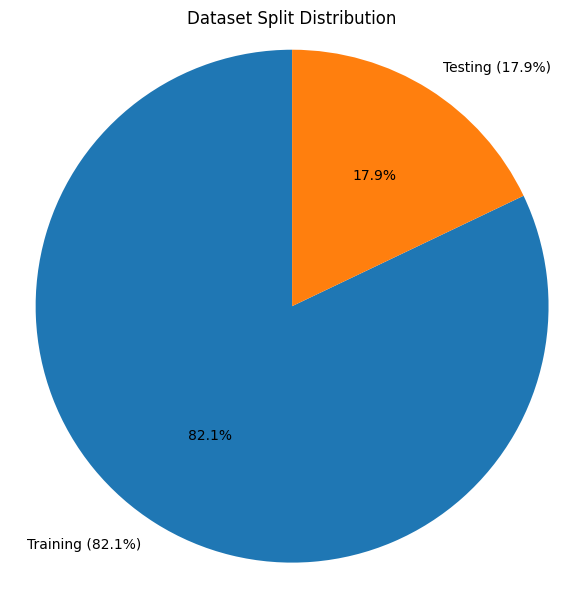

In [ ]:
# Load Dataset from Kaggle
data_dir = Path('/kaggle/input/dupl-remove/Dataset')

# Data Size Check
data_folder = ['Training', 'Testing']
counts = {}
for f in data_folder:
    each_folder_path = data_dir / f
    counts[f] = sum(1 for f in each_folder_path.rglob('*') if f.is_file())

for k, v in counts.items():
    print(f"{k}: {v} files")
total = sum(counts.values())
print(f"\nTotal : {total} files")

# Pie Chart for Dataset
plt.figure(figsize=(6, 6))
plt.pie(
    counts.values(),
    labels=[f"{k} ({v/total:.1%})" for k, v in counts.items()],
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Dataset Split Distribution")
plt.axis('equal')
plt.tight_layout()

# Save as pdf
save_dir = Path("/kaggle/working")
save_dir.mkdir(parents=True, exist_ok=True)
out_path = save_dir / "Dataset_Split_Distribution.pdf"
plt.savefig(out_path, format="pdf")
print("Saved to:", out_path)

plt.show()
plt.close()



# 4. Image Preprocessing

In [ ]:
# Dataset Path
train_dir = '/kaggle/input/dupl-remove/Dataset/Training'
test_dir = '/kaggle/input/dupl-remove/Dataset/Testing'

# Z-score Normalization (intensity Normalization )
class ZScoreNormalize(object):
    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            arr = img.numpy()
            arr = arr.transpose(1, 2, 0)  # C,H,W → H,W,C
        else:
            arr = np.array(img)
        arr = arr.astype(np.float32)
        mask = arr > 0  # if pixel > 0 ->True
        mean = arr[mask].mean() if mask.any() else arr.mean()
        std = arr[mask].std() if mask.any() else arr.std()
        arr = (arr - mean) / (std + 1e-8)
        arr = ((arr - arr.min()) / (arr.max() - arr.min() + 1e-8)) * 255.0
        arr = arr.astype(np.uint8)
        return Image.fromarray(arr)

# for XceptionNet, EfficientNet-B0
cnn_transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    ZScoreNormalize(),  # Z-score Normalization
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

cnn_transform_eval = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    ZScoreNormalize(),  # Z-score Normalization
    transforms.Resize(int(224 * 1.15)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# for ViT
vit_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
class ViTTransform:
    def __init__(self, train: bool = False):
        self.train = train
        self.znorm = ZScoreNormalize()  # Z-score normalization
    def __call__(self, image):
        image = image.convert('RGB')
        image = self.znorm(image)  # Z-score normalization
        tensor = vit_extractor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)
        if self.train and torch.rand(1) < 0.5:
            tensor = torch.flip(tensor, dims=[2])
        return tensor

vit_transform_train = ViTTransform(train=True)
vit_transform_eval  = ViTTransform(train=False)

# ImageFolder load
full_train_dataset_cnn = ImageFolder(train_dir, transform=cnn_transform_train)
test_dataset = ImageFolder(test_dir, transform=cnn_transform_eval)
full_train_dataset_vit = ImageFolder(train_dir, transform=vit_transform_train)
test_dataset_vit = ImageFolder(test_dir, transform=vit_transform_eval)

# Split train/validation (10% validation)
val_ratio = 0.1
val_size = int(len(full_train_dataset_cnn) * val_ratio)
train_size = len(full_train_dataset_cnn) - val_size

# split (CNN)
train_dataset_cnn, validation_dataset_cnn = random_split(
    full_train_dataset_cnn, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# split (ViT)
train_dataset_vit, validation_dataset_vit = random_split(
    full_train_dataset_vit, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# validation set need to use eval transform
validation_dataset_cnn.dataset.transform = cnn_transform_eval
validation_dataset_vit.dataset.transform = vit_transform_eval

# DataLoaders
train_loader = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_dataset_cnn, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
train_loader_vit = DataLoader(train_dataset_vit, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
validation_loader_vit = DataLoader(validation_dataset_vit, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Class mapping Check
print('Class mapping Check:', full_train_dataset_cnn.class_to_idx)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Class mapping Check: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 5. Prepare Models (CNN, XceptionNet, EfficientNet-B0, ViT)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# CNN (basic CNN)
model_cnn = CNN(num_classes=4)

# XceptionNet (heavy CNN)
model_xception = timm.create_model('xception', pretrained=True, num_classes=4)

# EfficientNet-B0 (light CNN)
model_efficient = timm.create_model('efficientnet_b0', pretrained=True, num_classes=4)

# ViT (Transformer)
model_vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=4,
    ignore_mismatched_sizes=True)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 6. Define the training function

In [ ]:
# {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]
NUM_CLASSES = len(CLASSES)
CLASS_INDICES = {c: i for i, c in enumerate(CLASSES)}

def train_model(model, train_loader, validation_loader, epochs=10, model_name=''):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Metrics tracking
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    train_precisions, train_recalls, train_f1s, train_aucs = [], [], [], []
    val_precisions, val_recalls, val_f1s, val_aucs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        all_train_preds = []
        all_train_labels = []
        all_train_probs = []

        for batch in train_loader:
            # Handle ViT or CNN input
            if isinstance(batch, dict):
                images = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
            else:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if hasattr(outputs, "logits"):  # For ViT models
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            all_train_preds.extend(outputs.argmax(1).cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            all_train_probs.extend(F.softmax(outputs, dim=1).detach().cpu().numpy())

        train_accuracy = correct / len(train_loader.dataset)
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_auc = roc_auc_score(
            label_binarize(all_train_labels, classes=list(range(NUM_CLASSES))),
            np.array(all_train_probs),
            multi_class="ovo",
        )

        # --- Validation ---
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_val_preds = []
        all_val_labels = []
        all_val_probs  = []

        with torch.no_grad():
            for batch in validation_loader:
                if isinstance(batch, dict):
                    images = batch["pixel_values"].to(device)
                    labels = batch["labels"].to(device)
                else:
                    images, labels = batch
                    images = images.to(device)
                    labels = labels.to(device)

                outputs = model(images)
                if hasattr(outputs, "logits"):  # For ViT models
                    outputs = outputs.logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                all_val_preds.extend(outputs.argmax(1).cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                all_val_probs.extend(F.softmax(outputs, dim=1).detach().cpu().numpy())

        val_accuracy = val_correct / len(validation_loader.dataset)
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_auc = roc_auc_score(
            label_binarize(all_val_labels, classes=list(range(NUM_CLASSES))),
            np.array(all_val_probs),
            multi_class="ovo",
        )

        # Save metrics
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss / len(validation_loader))
        val_accuracies.append(val_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        train_aucs.append(train_auc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        print(f"[Epoch {epoch+1}] Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save model weights after training
        if (epoch + 1) % 10 == 0:
            save_model_dir = "/kaggle/working/model"
            os.makedirs(save_model_dir, exist_ok=True)
            weights_path = os.path.join(save_model_dir, f"{model_name}_epoch{epoch+1}_weights.pth")
            metadata_path = os.path.join(save_model_dir, f"{model_name}_epoch{epoch+1}_metadata.pkl")
            torch.save(model.state_dict(), weights_path)
            metadata = {"class_names": CLASSES, "class_to_idx": CLASS_INDICES}
            joblib.dump(metadata, metadata_path)
            print(f"Model saved to {weights_path}")
            print(f"Metadata saved to {metadata_path}")


    # Call your metric plotting function
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions, train_recalls, val_recalls,
                 train_f1s, val_f1s, train_aucs, val_aucs, model_name)


# 7. Define Make metrics/graphs

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions, train_recalls, val_recalls,
                 train_f1s, val_f1s, train_aucs, val_aucs, model_name):
    # Loss
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(3, 2, 3)
    plt.plot(train_precisions, label='Train')
    plt.plot(val_precisions, label='Validation')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(3, 2, 4)
    plt.plot(train_recalls, label='Train')
    plt.plot(val_recalls, label='Validation')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # F1-Score
    plt.subplot(3, 2, 5)
    plt.plot(train_f1s, label='Train')
    plt.plot(val_f1s, label='Validation')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # AUC
    plt.subplot(3, 2, 6)
    plt.plot(train_aucs, label='Train')
    plt.plot(val_aucs, label='Validation')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()

    save_dir = "/kaggle/working"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{model_name}_Metrics_per_Epoch.pdf"), format='pdf')
    print(f"Saved: {save_dir}/{model_name}_Metrics_per_Epoch.pdf")

    plt.show()
    plt.close()

# 8. Define the evaluation fuction

In [ ]:
def evaluate_model(model, dataloader, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    y_probs = []  # Store probabilities for ROC curve

    with torch.no_grad():
        for batch in dataloader:

            if isinstance(batch, dict):  # for ViT
                images = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
            else:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

            outputs = model(images)

            # for ViT
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(1).cpu()

            y_pred.extend(preds.numpy())
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs.detach().cpu().numpy())


    # Classification report
    class_names = ["glioma", "meningioma", "notumor", "pituitary"]
    print(f"{model_name} Classification Report:\n{classification_report(y_true, y_pred, target_names=class_names)}")

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

    # Save metrics as json file
    save_dir = "/kaggle/working"
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, f"{model_name}_metrics.json"), "w") as f:
        json.dump(report, f, indent=4)
    print(f"Saved: {save_dir}/{model_name}_metrics.json")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(os.path.join(save_dir, f"{model_name}_Confusion_Matrix.pdf"), format='pdf')
    print(f"Saved: {save_dir}/{model_name}_Confusion_Matrix.pdf")
    plt.show()
    plt.close()

    # ROC curve
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), np.array(y_probs).ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, f"{model_name}_ROC_Curve.pdf"), format='pdf')
    print(f"Saved: {save_dir}/{model_name}_ROC_Curve.pdf")
    plt.show()
    plt.close()


# 9. Set up device (GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 10-1. Train CNN

Training basic CNN...
----------------------------------------
[Epoch 1] Train Acc: 0.4786, Val Acc: 0.4547
[Epoch 2] Train Acc: 0.5941, Val Acc: 0.5851
[Epoch 3] Train Acc: 0.6414, Val Acc: 0.6069
[Epoch 4] Train Acc: 0.6470, Val Acc: 0.6359
[Epoch 5] Train Acc: 0.6595, Val Acc: 0.6540
[Epoch 6] Train Acc: 0.6591, Val Acc: 0.6522
[Epoch 7] Train Acc: 0.6653, Val Acc: 0.6395
[Epoch 8] Train Acc: 0.6693, Val Acc: 0.6504
[Epoch 9] Train Acc: 0.6712, Val Acc: 0.6558
[Epoch 10] Train Acc: 0.6758, Val Acc: 0.6721
Model saved to /kaggle/working/model/CNN_weights.pth
Metadata saved to /kaggle/working/model/CNN_metadata.pkl
Saved: /kaggle/working/CNN_Metrics_per_Epoch.pdf


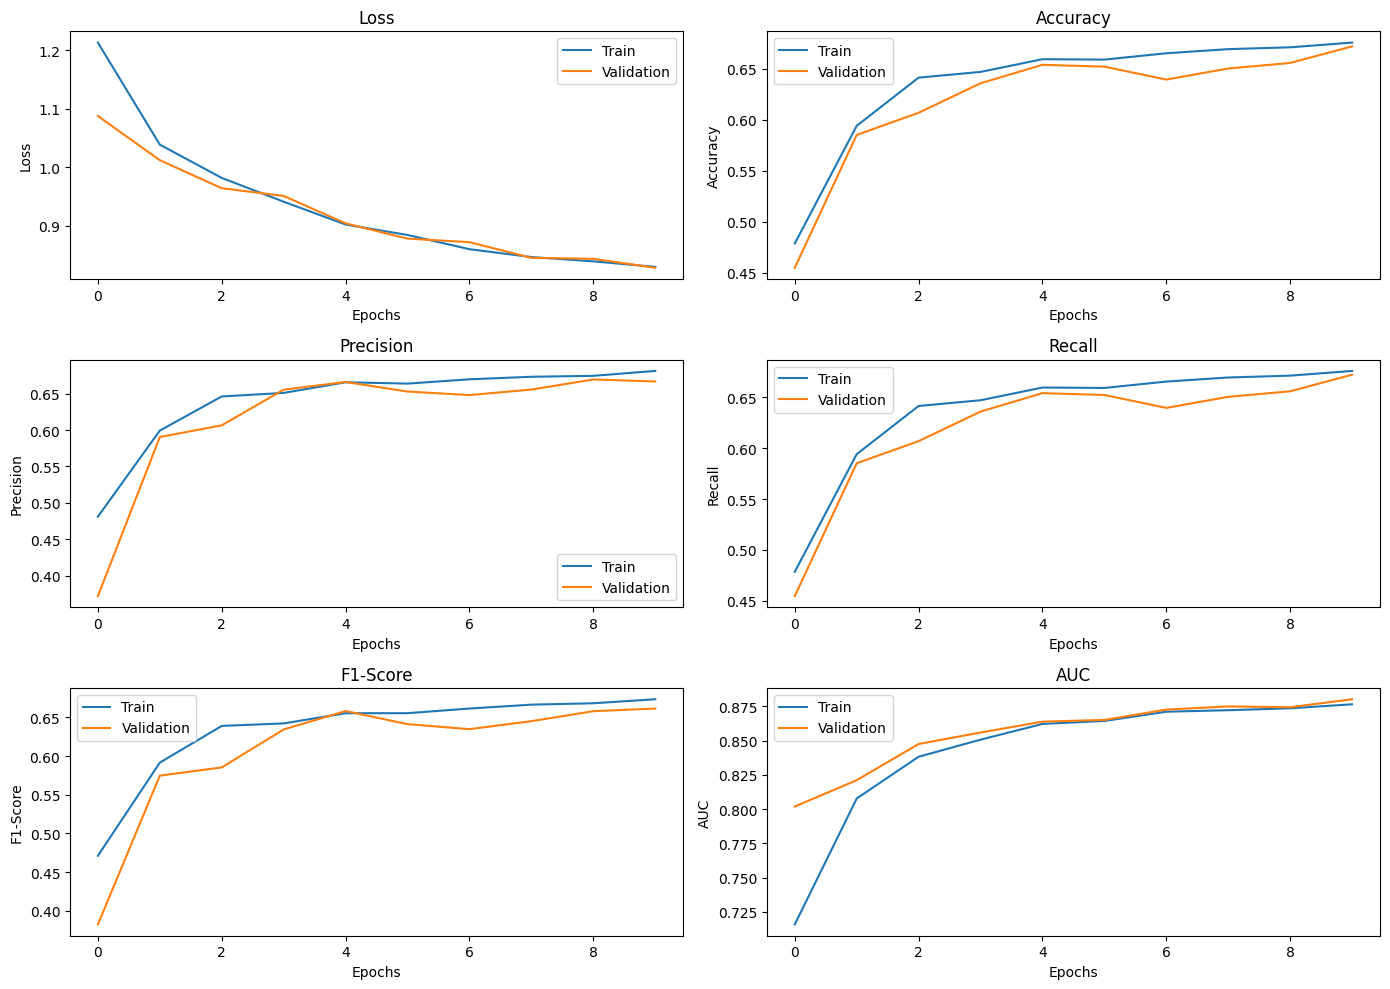

Training completed in 6.01 minutes


In [ ]:
print("Training basic CNN...")
print('-' * 40)
start_time = time.time()

train_model(model_cnn, train_loader, validation_loader, epochs=10, model_name='CNN')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 10-2. Evaluate CNN

CNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.60      0.70      0.65       299
  meningioma       0.48      0.25      0.33       302
     notumor       0.61      0.72      0.66       309
   pituitary       0.65      0.74      0.69       295

    accuracy                           0.60      1205
   macro avg       0.58      0.60      0.58      1205
weighted avg       0.58      0.60      0.58      1205

Saved: /kaggle/working/CNN_metrics.json
Saved: /kaggle/working/CNN_Confusion_Matrix.pdf


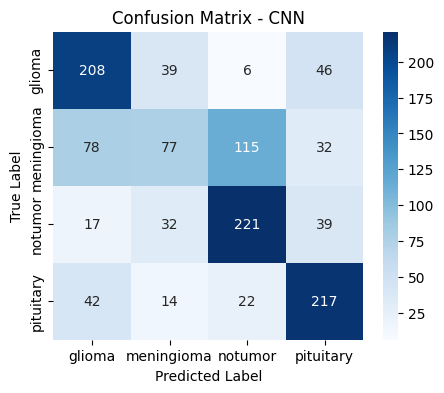

Saved: /kaggle/working/CNN_ROC_Curve.pdf


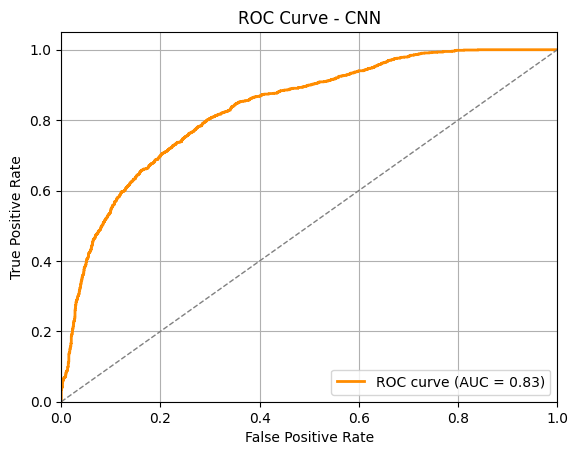

In [ ]:
#print(model_cnn)

evaluate_model(model_cnn, test_loader, "CNN")

# 11-1. Train CNN (epoch=100)

Training basic CNN epoch 100...
----------------------------------------
[Epoch 1] Train Acc: 0.7340, Val Acc: 0.7029
[Epoch 2] Train Acc: 0.7396, Val Acc: 0.7047
[Epoch 3] Train Acc: 0.7418, Val Acc: 0.7083
[Epoch 4] Train Acc: 0.7392, Val Acc: 0.7246
[Epoch 5] Train Acc: 0.7394, Val Acc: 0.7156
[Epoch 6] Train Acc: 0.7390, Val Acc: 0.7138
[Epoch 7] Train Acc: 0.7402, Val Acc: 0.6975
[Epoch 8] Train Acc: 0.7364, Val Acc: 0.7138
[Epoch 9] Train Acc: 0.7450, Val Acc: 0.7464
[Epoch 10] Train Acc: 0.7420, Val Acc: 0.7156
Model saved to /kaggle/working/model/CNN_epoch10_weights.pth
Metadata saved to /kaggle/working/model/CNN_epoch10_metadata.pkl
[Epoch 11] Train Acc: 0.7448, Val Acc: 0.7301
[Epoch 12] Train Acc: 0.7498, Val Acc: 0.7283
[Epoch 13] Train Acc: 0.7501, Val Acc: 0.7264
[Epoch 14] Train Acc: 0.7466, Val Acc: 0.7355
[Epoch 15] Train Acc: 0.7462, Val Acc: 0.7283
[Epoch 16] Train Acc: 0.7519, Val Acc: 0.7319
[Epoch 17] Train Acc: 0.7428, Val Acc: 0.7138
[Epoch 18] Train Acc: 0.7503

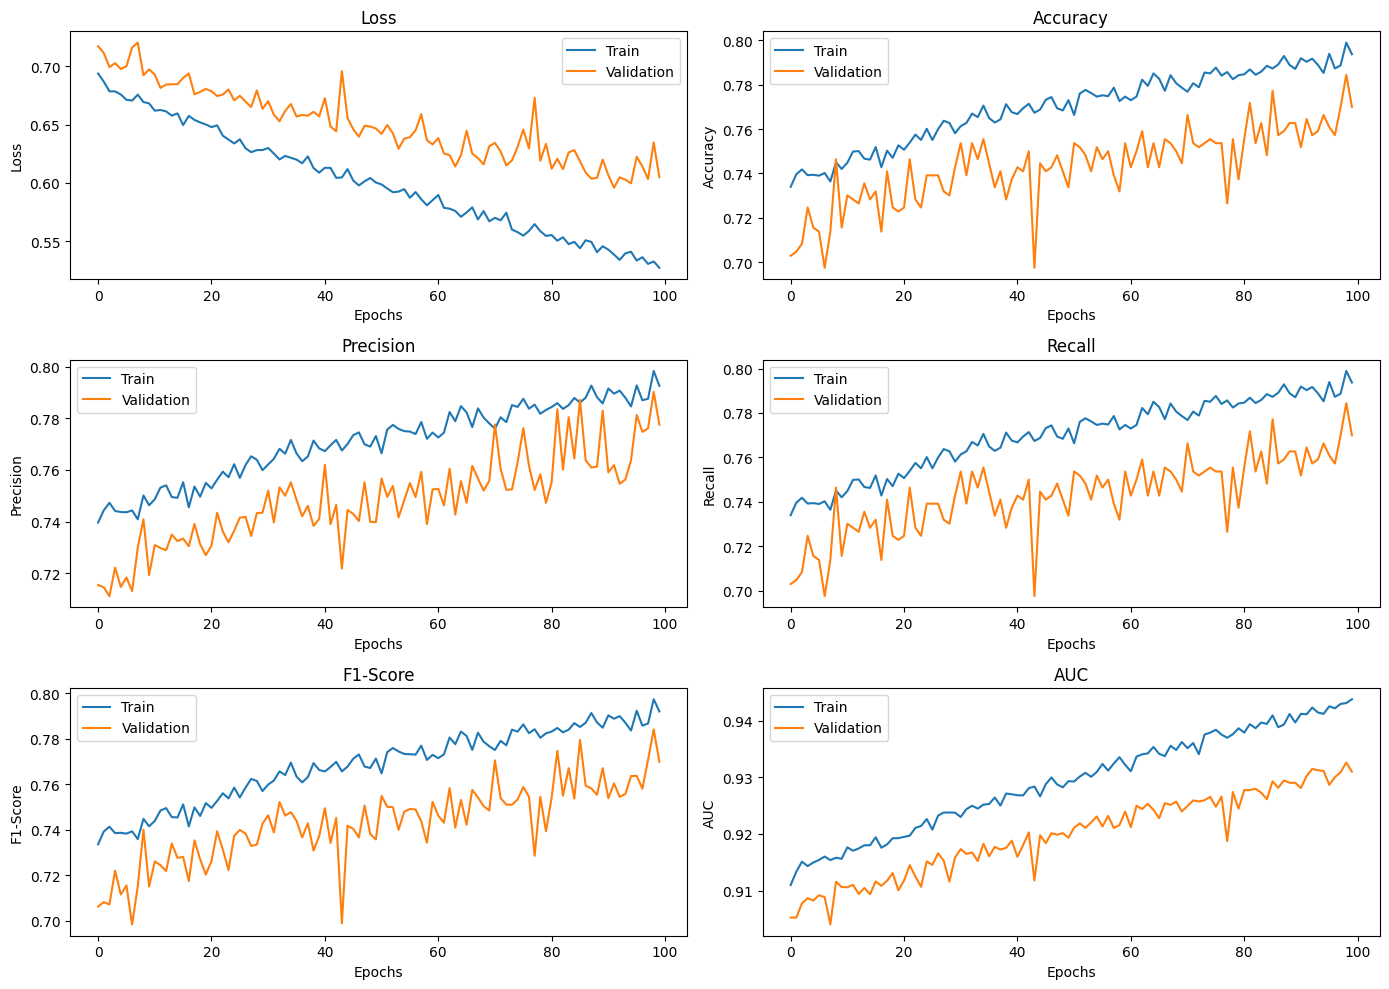

Training completed in 59.62 minutes


In [ ]:
print("Training basic CNN epoch 100...")
print('-' * 40)
start_time = time.time()

train_model(model_cnn, train_loader, validation_loader, epochs=100, model_name='CNN')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 11-2. Evaluate CNN (epoch=100)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
CNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.79      0.61      0.69       299
  meningioma       0.62      0.58      0.60       302
     notumor       0.83      0.94      0.88       309
   pituitary       0.75      0.87      0.80       295

    accuracy                           0.75      1205
   macro avg       0.75      0.75      0.75      1205
weighted avg       0.75      0.75      0.75      1205

Saved: /kaggle/working/CNN_metrics.json
Saved: /kaggle/working/CNN_Confusion_Matrix.pdf


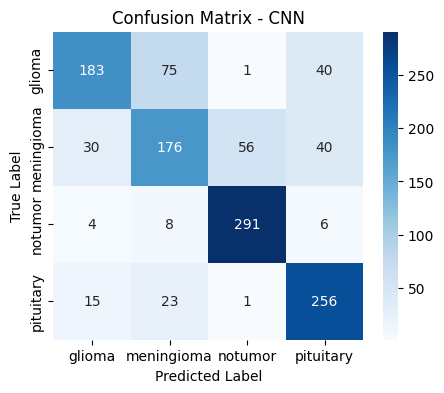

Saved: /kaggle/working/CNN_ROC_Curve.pdf


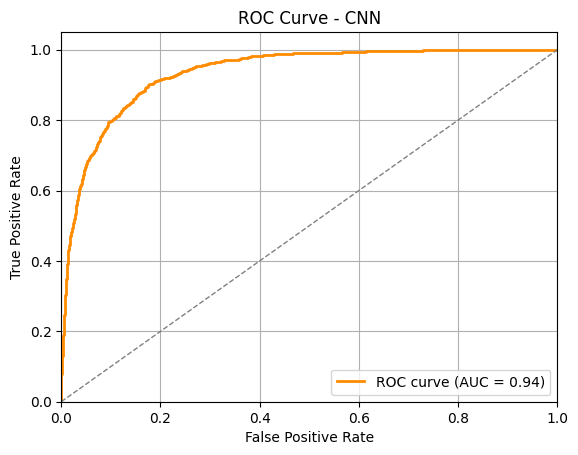

In [ ]:
#print(model_cnn)

evaluate_model(model_cnn, test_loader, "CNN")

# 12-1. Train XceptionNet

Training XceptionNet...
----------------------------------------
[Epoch 1] Train Acc: 0.8929, Val Acc: 0.9529
[Epoch 2] Train Acc: 0.9849, Val Acc: 0.9819
[Epoch 3] Train Acc: 0.9954, Val Acc: 0.9674
[Epoch 4] Train Acc: 0.9944, Val Acc: 0.9764
[Epoch 5] Train Acc: 0.9984, Val Acc: 0.9764
[Epoch 6] Train Acc: 0.9946, Val Acc: 0.9692
[Epoch 7] Train Acc: 0.9966, Val Acc: 0.9837
[Epoch 8] Train Acc: 0.9958, Val Acc: 0.9801
[Epoch 9] Train Acc: 0.9984, Val Acc: 0.9783
[Epoch 10] Train Acc: 0.9982, Val Acc: 0.9783
Model saved to /kaggle/working/model/Xception_weights.pth
Metadata saved to /kaggle/working/model/Xception_metadata.pkl
Saved: /kaggle/working/Xception_Metrics_per_Epoch.pdf


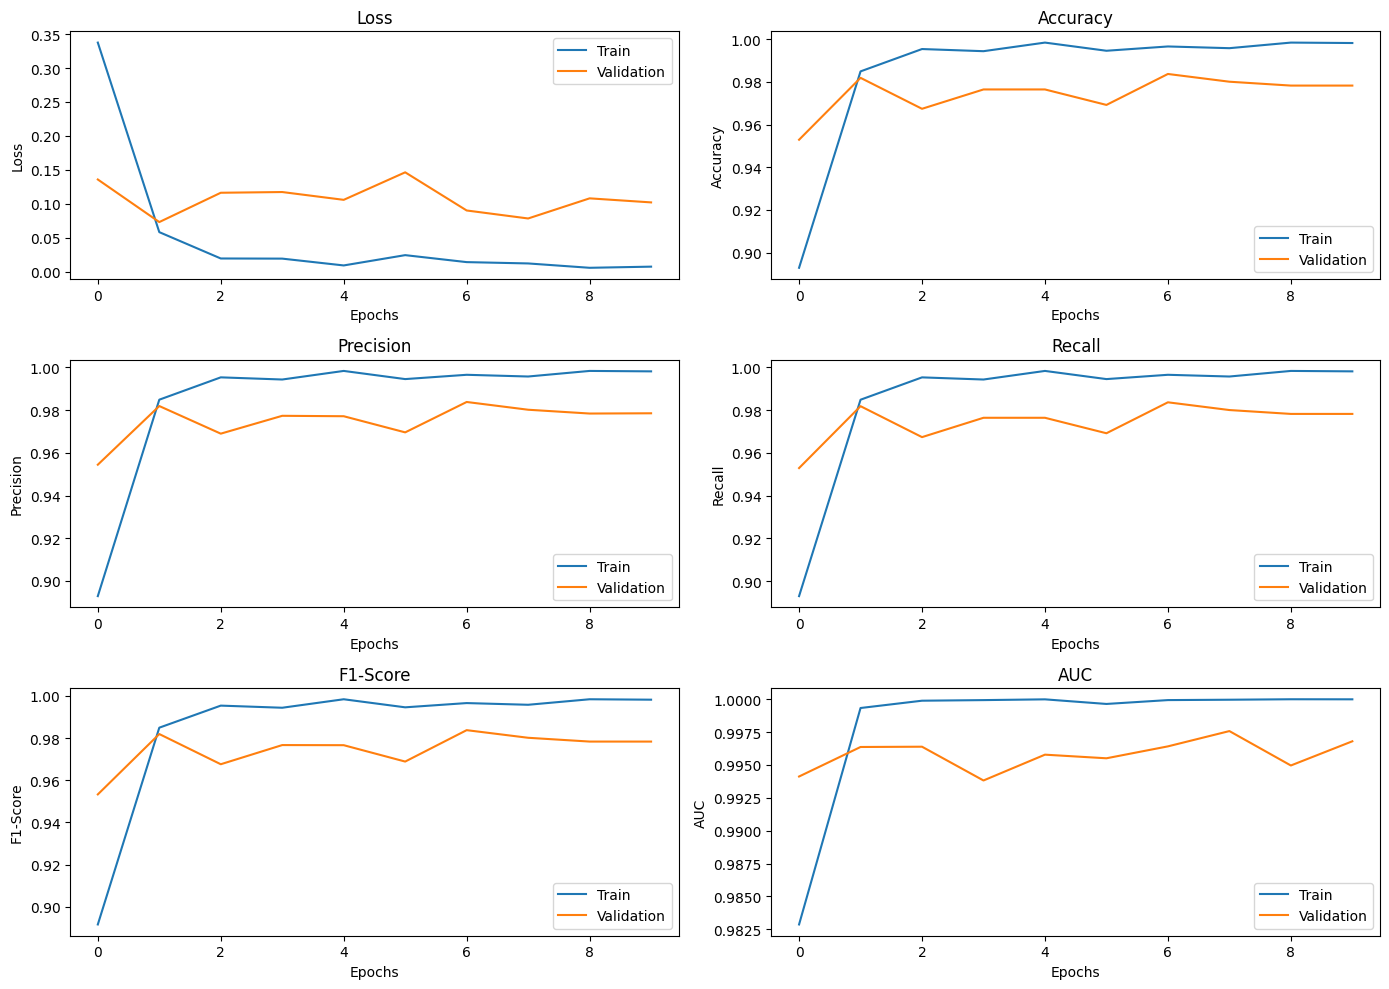

Training completed in 16.00 minutes


In [ ]:
print("Training XceptionNet...")
print('-' * 40)
start_time = time.time()

train_model(model_xception, train_loader, validation_loader, epochs=10, model_name='Xception')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 12-2. Evaluate XceptionNet

Xception Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       299
  meningioma       0.96      0.99      0.97       302
     notumor       1.00      1.00      1.00       309
   pituitary       0.99      0.99      0.99       295

    accuracy                           0.99      1205
   macro avg       0.99      0.99      0.99      1205
weighted avg       0.99      0.99      0.99      1205

Saved: /kaggle/working/Xception_metrics.json
Saved: /kaggle/working/Xception_Confusion_Matrix.pdf


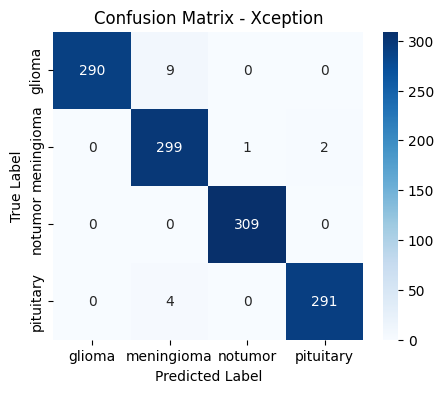

Saved: /kaggle/working/Xception_ROC_Curve.pdf


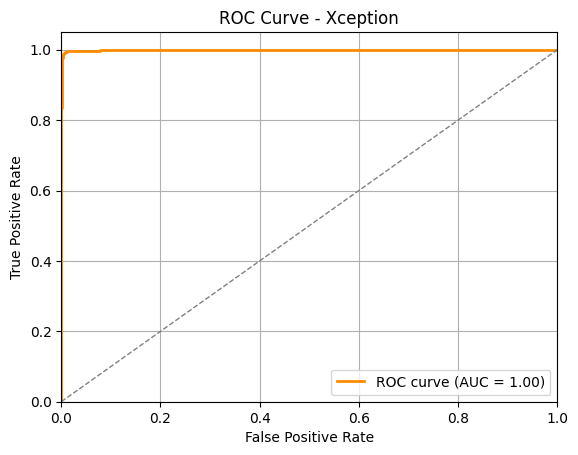

In [ ]:
#print(model_xception)

evaluate_model(model_xception, test_loader, "Xception")

# 13-1. Train EfficientNet-B0

Training EfficientNet-B0...
----------------------------------------
[Epoch 1] Train Acc: 0.8571, Val Acc: 0.9420
[Epoch 2] Train Acc: 0.9744, Val Acc: 0.9601
[Epoch 3] Train Acc: 0.9930, Val Acc: 0.9674
[Epoch 4] Train Acc: 0.9954, Val Acc: 0.9728
[Epoch 5] Train Acc: 0.9958, Val Acc: 0.9764
[Epoch 6] Train Acc: 0.9988, Val Acc: 0.9674
[Epoch 7] Train Acc: 0.9988, Val Acc: 0.9746
[Epoch 8] Train Acc: 0.9992, Val Acc: 0.9746
[Epoch 9] Train Acc: 0.9990, Val Acc: 0.9764
[Epoch 10] Train Acc: 0.9992, Val Acc: 0.9764
Model saved to /kaggle/working/model/EfficientNet_weights.pth
Metadata saved to /kaggle/working/model/EfficientNet_metadata.pkl
Saved: /kaggle/working/EfficientNet_Metrics_per_Epoch.pdf


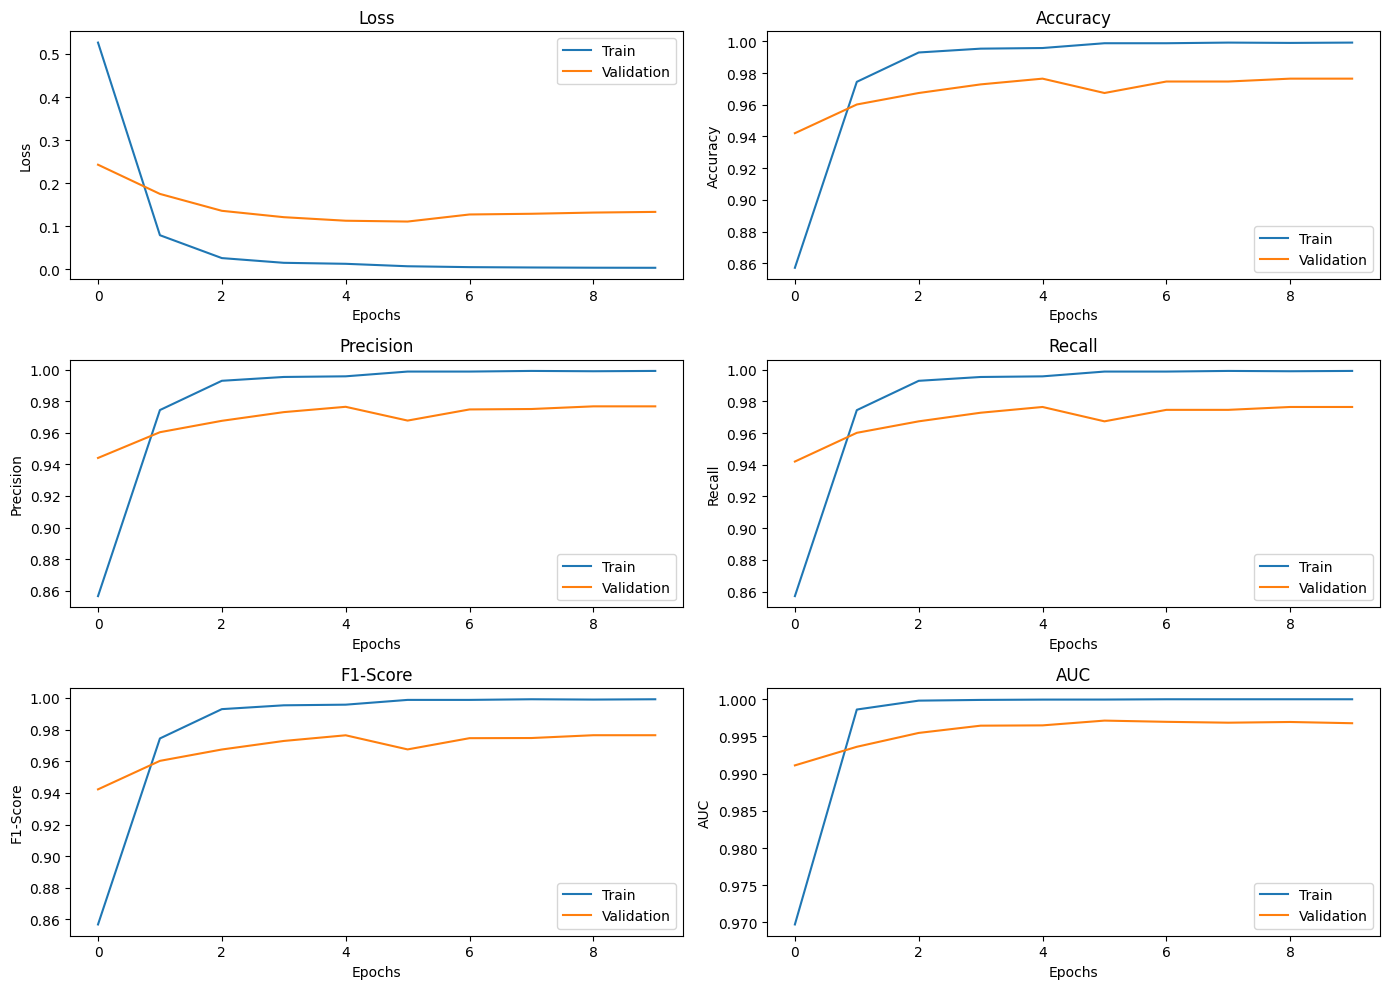

Training completed in 6.62 minutes


In [ ]:
print("Training EfficientNet-B0...")
print('-' * 40)
start_time = time.time()

train_model(model_efficient, train_loader, validation_loader, epochs=10, model_name='EfficientNet')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")



# 13-2. Evaluate EfficientNet-B0

EfficientNet Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       299
  meningioma       0.96      0.96      0.96       302
     notumor       0.98      1.00      0.99       309
   pituitary       0.99      0.99      0.99       295

    accuracy                           0.98      1205
   macro avg       0.98      0.98      0.98      1205
weighted avg       0.98      0.98      0.98      1205

Saved: /kaggle/working/EfficientNet_metrics.json
Saved: /kaggle/working/EfficientNet_Confusion_Matrix.pdf


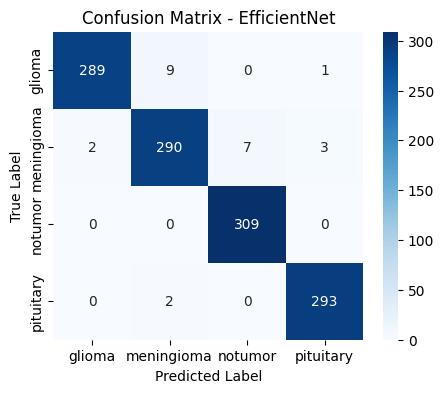

Saved: /kaggle/working/EfficientNet_ROC_Curve.pdf


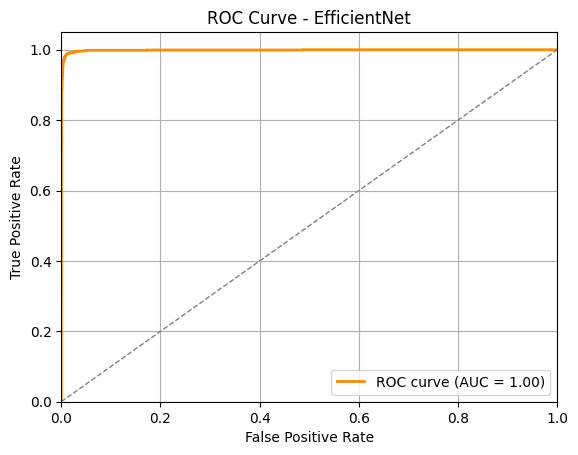

In [ ]:
#print(model_efficient)

evaluate_model(model_efficient, test_loader, "EfficientNet")

# 14-1. Train ViT

Training ViT...
----------------------------------------
[Epoch 1] Train Acc: 0.9213, Val Acc: 0.9529
[Epoch 2] Train Acc: 0.9867, Val Acc: 0.9764
[Epoch 3] Train Acc: 0.9950, Val Acc: 0.9819
[Epoch 4] Train Acc: 0.9899, Val Acc: 0.9891
[Epoch 5] Train Acc: 0.9950, Val Acc: 0.9819
[Epoch 6] Train Acc: 0.9984, Val Acc: 0.9801
[Epoch 7] Train Acc: 0.9968, Val Acc: 0.9837
[Epoch 8] Train Acc: 0.9855, Val Acc: 0.9384
[Epoch 9] Train Acc: 0.9928, Val Acc: 0.9783
[Epoch 10] Train Acc: 0.9966, Val Acc: 0.9656
Model saved to /kaggle/working/model/ViT_weights.pth
Metadata saved to /kaggle/working/model/ViT_metadata.pkl
Saved: /kaggle/working/ViT_Metrics_per_Epoch.pdf


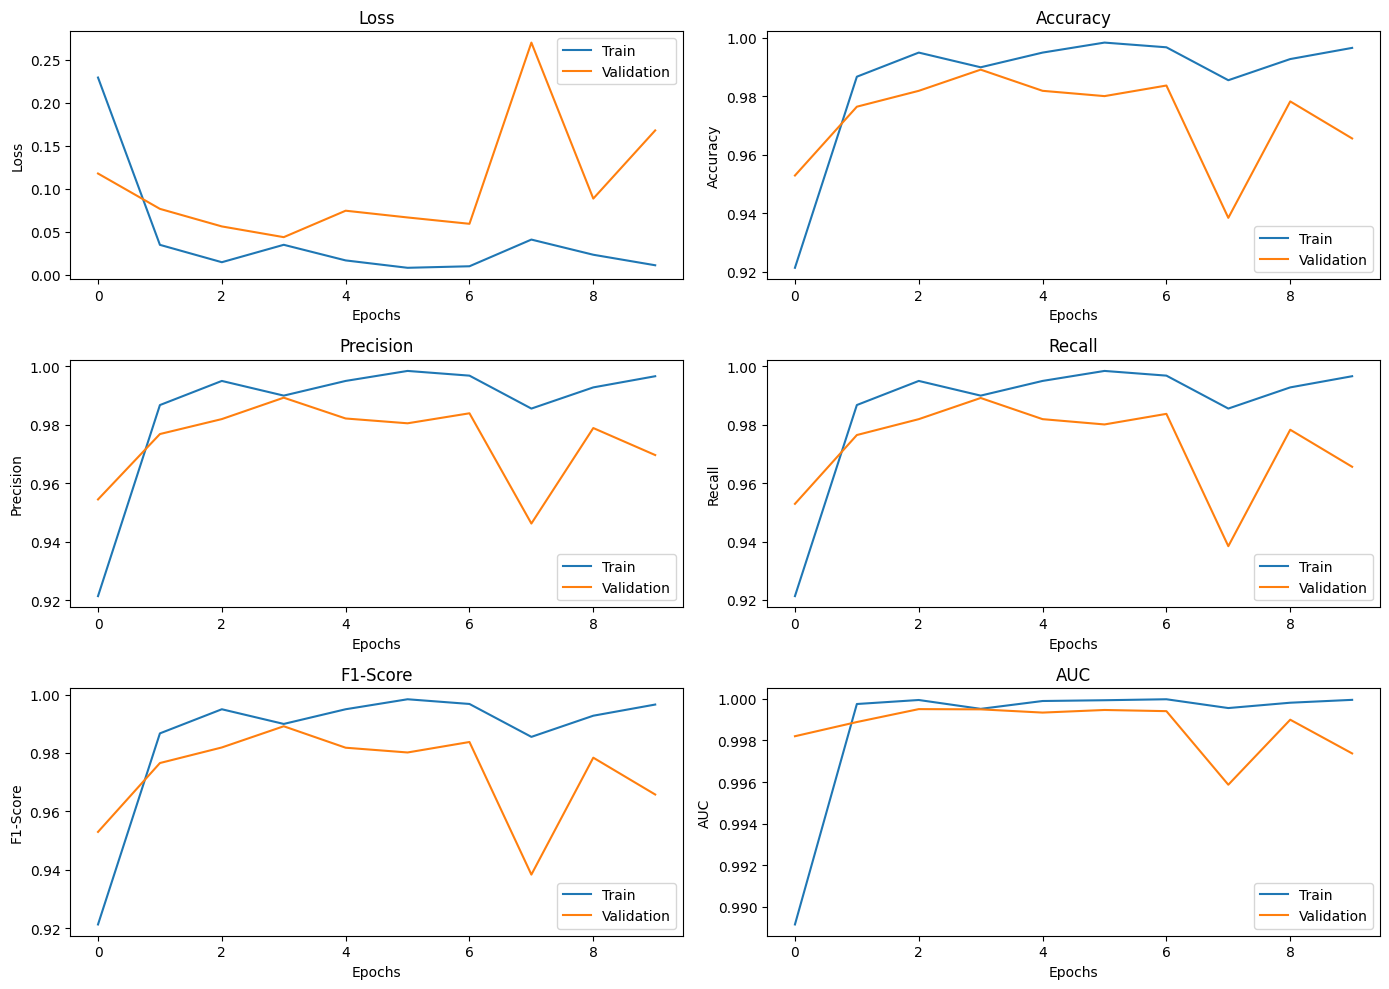

Training completed in 33.51 minutes


In [ ]:
print("Training ViT...")
print('-' * 40)
start_time = time.time()

train_model(model_vit, train_loader_vit, validation_loader_vit, epochs=10, model_name='ViT')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 14-2. Evaluate ViT

ViT Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.85      0.92       299
  meningioma       0.87      1.00      0.93       302
     notumor       1.00      1.00      1.00       309
   pituitary       1.00      0.99      1.00       295

    accuracy                           0.96      1205
   macro avg       0.97      0.96      0.96      1205
weighted avg       0.97      0.96      0.96      1205

Saved: /kaggle/working/ViT_metrics.json
Saved: /kaggle/working/ViT_Confusion_Matrix.pdf


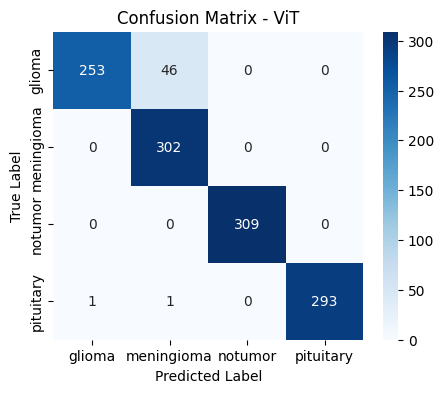

Saved: /kaggle/working/ViT_ROC_Curve.pdf


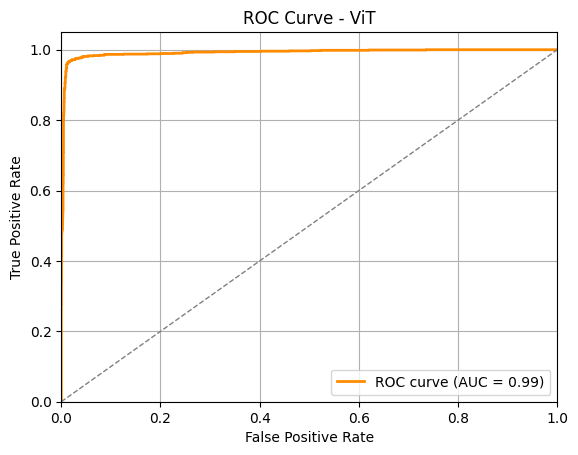

In [ ]:
#print(model_vit)

evaluate_model(model_vit, test_loader_vit, "ViT")

# 15. Compare 4 Models (CNN, XceptionNet, EfficientNet-B0, ViT)

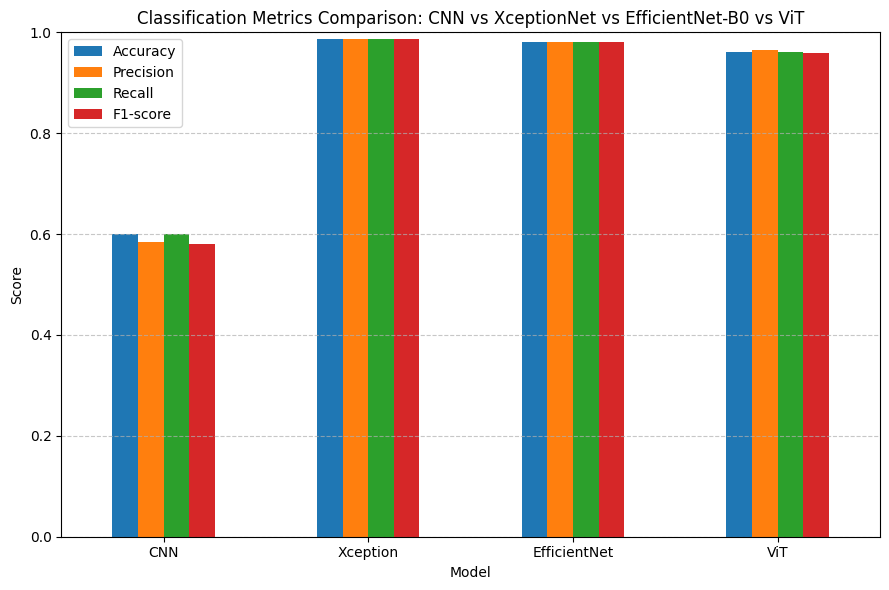

In [ ]:
# Models
model_names = ["CNN", "Xception", "EfficientNet", "ViT"]

# metrics list
metrics_data = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

# path
metrics_dir = "/kaggle/input/trained-model/model"
save_dir = "/kaggle/working/"

# Load metrics
for model in model_names:
    file_path = os.path.join(metrics_dir, f"{model}_metrics.json")
    with open(file_path, "r") as f:
        report = json.load(f)

    metrics_data["Model"].append(model)
    metrics_data["Accuracy"].append(report["accuracy"])
    metrics_data["Precision"].append(report["weighted avg"]["precision"])
    metrics_data["Recall"].append(report["weighted avg"]["recall"])
    metrics_data["F1-score"].append(report["weighted avg"]["f1-score"])

# DataFrame
df = pd.DataFrame(metrics_data)

# Visualization
df.plot(kind='bar', x='Model', figsize=(9,6),
        title="Classification Metrics Comparison: CNN vs XceptionNet vs EfficientNet-B0 vs ViT")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Model_Comparison_Plot.pdf"), format='pdf')
plt.show()
plt.close()


# 16. Grad-CAM (CNN, XceptionNet, EfficientNet-B0)

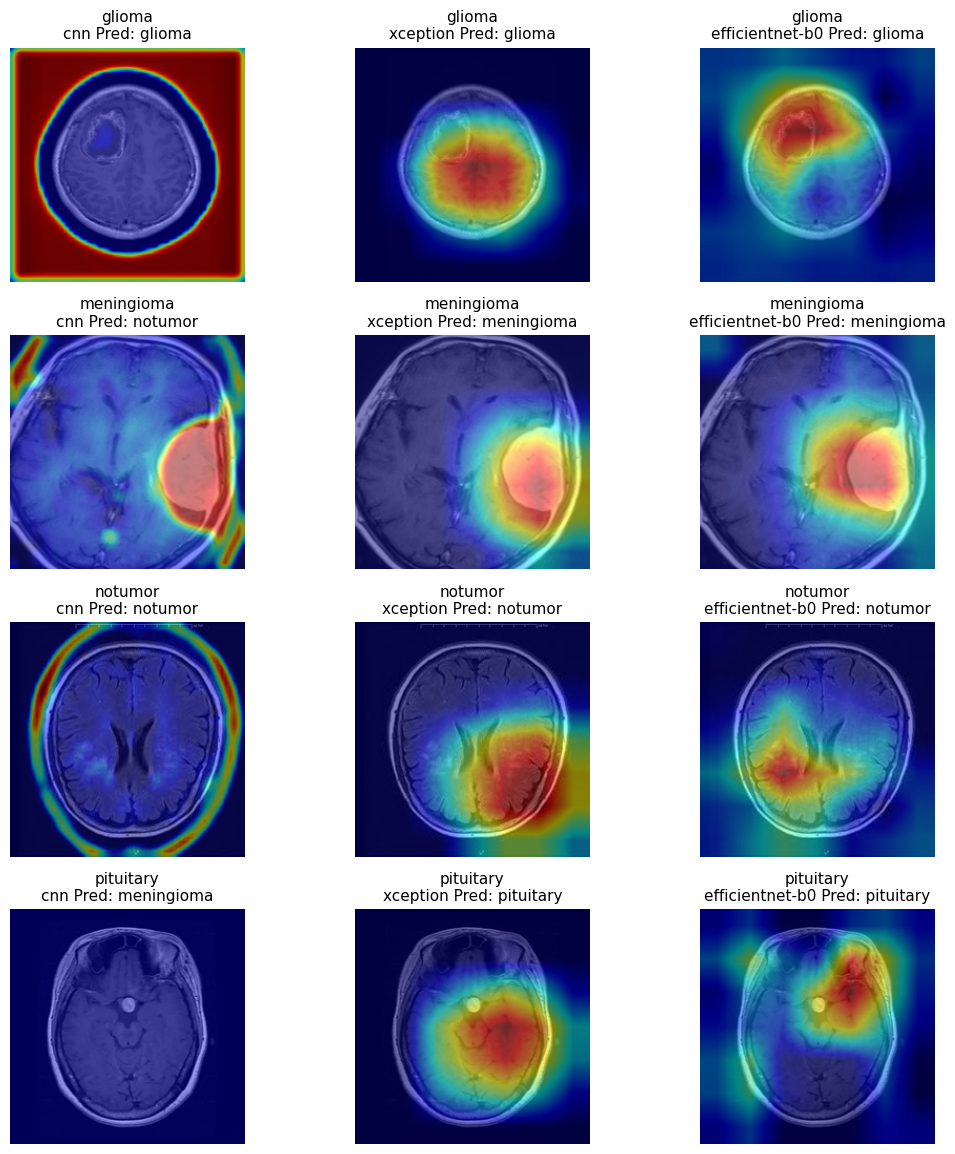

In [ ]:
# Define base directory
base_dir = Path('/kaggle/input/test-gradcam/')
base_output_dir = Path('/kaggle/input/trained-model/model')
model_paths = {
    "xception": {
        "weights": base_output_dir / "Xception_weights.pth",
        "metadata": base_output_dir / "Xception_metadata.pkl",
    },
    "efficientnet-b0": {
        "weights": base_output_dir / "EfficientNet_weights.pth",
        "metadata": base_output_dir / "EfficientNet_metadata.pkl",
    },
    "cnn": {
        "weights": base_output_dir / "CNN_weights.pth",
        "metadata": base_output_dir / "CNN_metadata.pkl",
    }
}
image_paths = {
    "glioma": os.path.join(base_dir, "Te-gl_0293.jpg"),  # For test
    "meningioma": os.path.join(base_dir, "Te-me_0012.jpg"), # For test
    "notumor": os.path.join(base_dir, "Te-no_0190.jpg"), # For test
    "pituitary": os.path.join(base_dir, "Te-pi_0154.jpg") # For test
}



# get model and target layer
def get_model(model_name, num_classes):
    # print(model_name)
    if model_name.lower() == "xception":
        model = timm.create_model("xception", pretrained=False, num_classes=num_classes)
        target_layer = model.conv4.pointwise  # last conv block
    elif model_name.lower() == "efficientnet-b0":
        model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
        target_layer = model.conv_head  # last conv block
    elif model_name.lower() == "cnn":
        model = CNN(num_classes=num_classes)
        target_layer = model.conv3  # last conv block
    else:
        print("Check model name!")
    return model, target_layer

# Define image preprocessing pipeline (same with trained model image pipeline)
def get_transform(input_size):
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(int(input_size[0] * 1.15)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

def load_image(path, transform, input_size):
    image = Image.open(path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    image_np = np.array(image.resize(input_size)) / 255.0
    return image_tensor, image_np

def apply_gradcam(model, image_tensor, image_np, target_layer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
    # with GradCAMPlusPlus(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=image_tensor)[0]
        visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        return visualization

all_visual_results = []
all_pred_info = []
model_order = ["cnn", "xception", "efficientnet-b0"]
class_order = ["glioma", "meningioma", "notumor", "pituitary"]

# Grad-CAM visualization
for label in class_order:
    row_imgs = []
    row_infos = []

    for model_name in model_order:
        cfg = model_paths[model_name]
        metadata = joblib.load(cfg["metadata"])
        class_names = metadata.get("class_names", class_order)
        input_size = metadata.get("input_size", (224, 224))

        model, target_layer = get_model(model_name.lower(), num_classes=len(class_names))
        model.load_state_dict(torch.load(cfg["weights"], map_location="cpu"))
        model.eval()

        transform = get_transform(input_size)

        path = image_paths[label]
        input_tensor, input_np = load_image(path, transform, input_size)
        with torch.no_grad():
            output = model(input_tensor)
            pred_idx = torch.argmax(output, dim=1).item()
            pred_class = class_names[pred_idx]
            prob = torch.nn.functional.softmax(output, dim=1)[0, pred_idx].item()

        visualization = apply_gradcam(model, input_tensor, input_np, target_layer)
        row_imgs.append(visualization)
        # row_infos.append(f"{label}\n{model_name} Pred: {pred_class} ({prob:.2%})")
        row_infos.append(f"{label}\n{model_name} Pred: {pred_class}")

    all_visual_results.append(row_imgs)
    all_pred_info.append(row_infos)

# all images save as one file
fig, axes = plt.subplots(4, 3, figsize=(11, 12))

for i in range(4):  # class
    for j in range(3):  # model
        ax = axes[i, j]
        ax.imshow(all_visual_results[i][j])
        ax.set_title(all_pred_info[i][j], fontsize=11)
        ax.axis("off")

# class label (y)
for ax, class_name in zip(axes[:, 0], class_order):
    ax.set_ylabel(class_name.capitalize(), fontsize=16, rotation=0, labelpad=40, weight='bold', va='center')
# model name (x)
for ax, model_name in zip(axes[0, :], model_order):
    ax.set_xlabel(model_name.upper(), fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.97])

save_path = os.path.join("/kaggle/working/", "All_GradCAM.pdf")
plt.savefig(save_path, format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()


# RQ1: Model Performance
*How do the ViT, XceptionNet, EfficientNet-B0, and a basic CNN differ in terms of accuracy, precision, recall, and other key performance metrics when detecting brain tumors from MRI images?*


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
----------------------------------------
Model                Params(M)       FLOPs(G)
CNN                       0.09           0.52
XceptionNet              20.82           4.60
EfficientNet-B0           4.01           0.39
ViT                      85.80          16.87


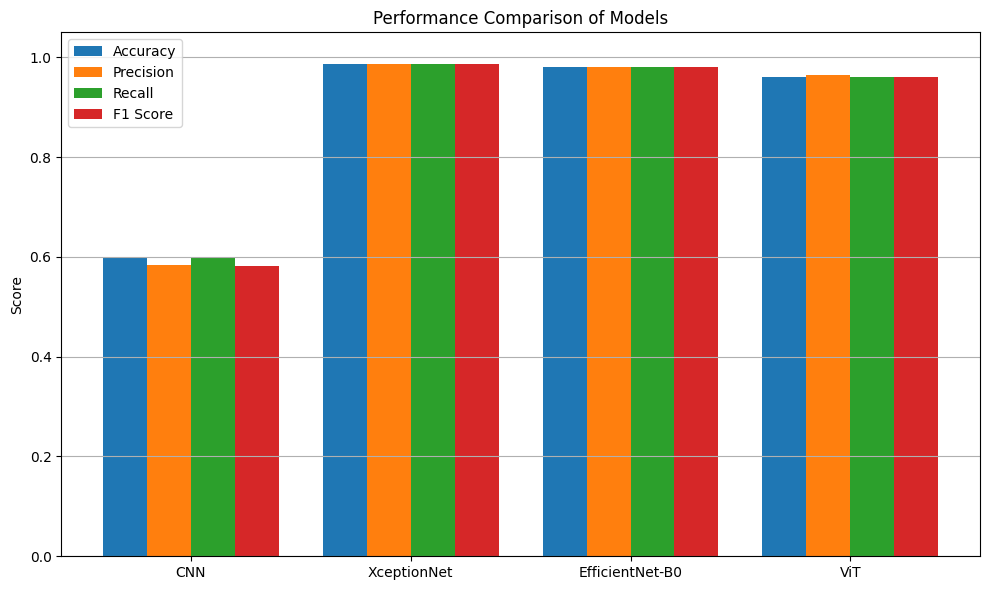

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Set path and model filenames
base_dir = '/content/drive/MyDrive/UE/BrainTumorDetection'

model_files = {
    'CNN':            'CNN_metrics.json',
    'XceptionNet':    'Xception_metrics.json',
    'EfficientNet-B0':'EfficientNet_metrics.json',
    'ViT':            'ViT_metrics.json'
}

# 4. Set input size for each model
input_size_dict = {
    "cnn": (3, 224, 224),
    "xception": (3, 224, 224),
    "efficientnet_b0": (3, 224, 224),
    "vit": (3, 224, 224)
}

# 5. Prepare model objects (already defined in your environment)
models = {
    "CNN": (model_cnn, input_size_dict["cnn"]),
    "XceptionNet": (model_xception, input_size_dict["xception"]),
    "EfficientNet-B0": (model_efficient, input_size_dict["efficientnet_b0"]),
    "ViT": (model_vit, input_size_dict["vit"])
}

# 6. Calculate Params and FLOPs for each model
print('-' * 40)
print(f"{'Model':<18}{'Params(M)':>12}{'FLOPs(G)':>15}")

model_params = {}
for name, (model, input_shape) in models.items():
    model.eval()
    macs, params = get_model_complexity_info(
        model, input_shape, as_strings=False, print_per_layer_stat=False, verbose=False
    )
    print(f"{name:<18}{params/1e6:12.2f}{macs/1e9:15.2f}")
    model_params[name] = round(params / 1e6, 2)  # Params in Millions, rounded

# 7. Load metrics from JSON files and extract "macro avg" + "accuracy"
metrics = {}
for model, fname in model_files.items():
    fpath = os.path.join(base_dir, fname)
    with open(fpath, 'r') as f:
        data = json.load(f)
        accuracy = data.get('accuracy', 0)
        macro = data.get('macro avg', {})
        precision = macro.get('precision', 0)
        recall = macro.get('recall', 0)
        f1 = macro.get('f1-score', 0)
        metrics[model] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }

# 8. Create a pandas DataFrame for performance metrics
rows = []
for model in model_files.keys():
    met = metrics[model]
    rows.append({
        'Model': model,
        'Accuracy': met['Accuracy'],
        'Precision': met['Precision'],
        'Recall': met['Recall'],
        'F1': met['F1'],
        'Parameters(M)': model_params[model]
    })
df = pd.DataFrame(rows)

# 9. Bar Chart: Model-wise performance comparison
labels = df['Model']
bar_width = 0.2
x = np.arange(len(labels))

plt.figure(figsize=(10,6))
plt.bar(x - bar_width*1.5, df['Accuracy'], bar_width, label='Accuracy')
plt.bar(x - bar_width/2,  df['Precision'], bar_width, label='Precision')
plt.bar(x + bar_width/2,  df['Recall'], bar_width, label='Recall')
plt.bar(x + bar_width*1.5,df['F1'], bar_width, label='F1 Score')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Performance Comparison of Models")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UE/BrainTumorDetection/RQ1/RQ1_Model_Performance_Comparison.pdf')  # save as PDF
plt.show()
plt.close()



# RQ2: Model Complexity & Architecture
*How does model complexity (such as number of parameters and computational cost) or architectural choice (CNN vs. Transformer) influence the performance and efficiency of these models in brain tumor detection?*

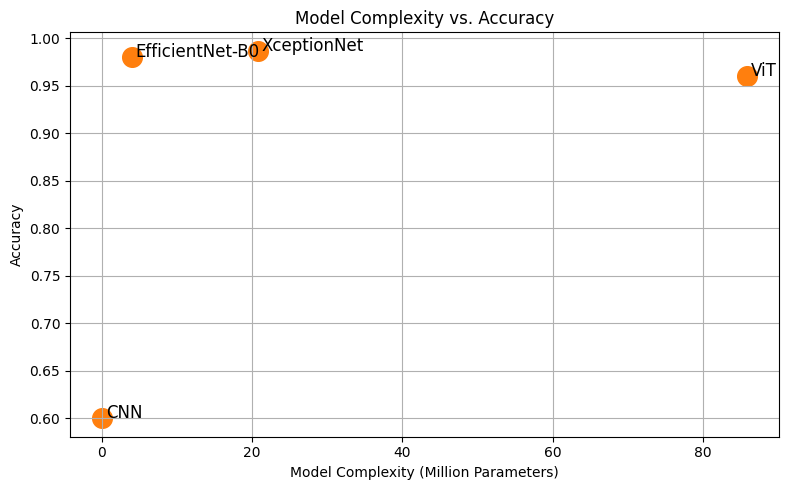

Model-wise Performance Summary:


,Model,Accuracy,Precision,Recall,F1,Parameters(M)
0,CNN,0.600000,0.583763,0.600356,0.581151,0.09
1,XceptionNet,0.986722,0.987070,0.986602,0.986710,20.82
2,EfficientNet-B0,0.980083,0.980241,0.980010,0.980046,4.01
3,ViT,0.960166,0.965348,0.959844,0.959853,85.80


In [ ]:
# Scatter Plot: Model Complexity (parameters) vs Accuracy
plt.figure(figsize=(8,5))
plt.scatter(df['Parameters(M)'], df['Accuracy'], s=200, color='C1')
for i, row in df.iterrows():
    plt.annotate(row['Model'], (row['Parameters(M)']+0.5, row['Accuracy']), fontsize=12)
plt.xlabel("Model Complexity (Million Parameters)")
plt.ylabel("Accuracy")
plt.title("Model Complexity vs. Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UE/BrainTumorDetection/RQ2/RQ2_Model_Complexity_Comparison.pdf')  # save as PDF
plt.show()
plt.close()

# Display Summary Table
print("Model-wise Performance Summary:")
display(df)


# RQ3: Error Analysis
*Which tumor types are most frequently misclassified by each model, and what patterns or trends can be observed from the confusion matrices and class-wise metrics?*

,Model,Class,Precision,Recall,F1-Score,Support
0,CNN,glioma,0.602899,0.695652,0.645963,299
1,CNN,meningioma,0.475309,0.254967,0.331897,302
2,CNN,notumor,0.607143,0.715210,0.656761,309
3,CNN,pituitary,0.649701,0.735593,0.689984,295
4,EfficientNet-B0,glioma,0.993127,0.966555,0.979661,299
5,EfficientNet-B0,meningioma,0.963455,0.960265,0.961857,302
6,EfficientNet-B0,notumor,0.977848,1.000000,0.988800,309
7,EfficientNet-B0,pituitary,0.986532,0.993220,0.989865,295
8,ViT,glioma,0.996063,0.846154,0.915009,299
9,ViT,meningioma,0.865330,1.000000,0.927803,302


Excel file saved as '/content/drive/MyDrive/UE/BrainTumorDetection/RQ3/RQ3_classwise_metrics_by_model.xlsx'


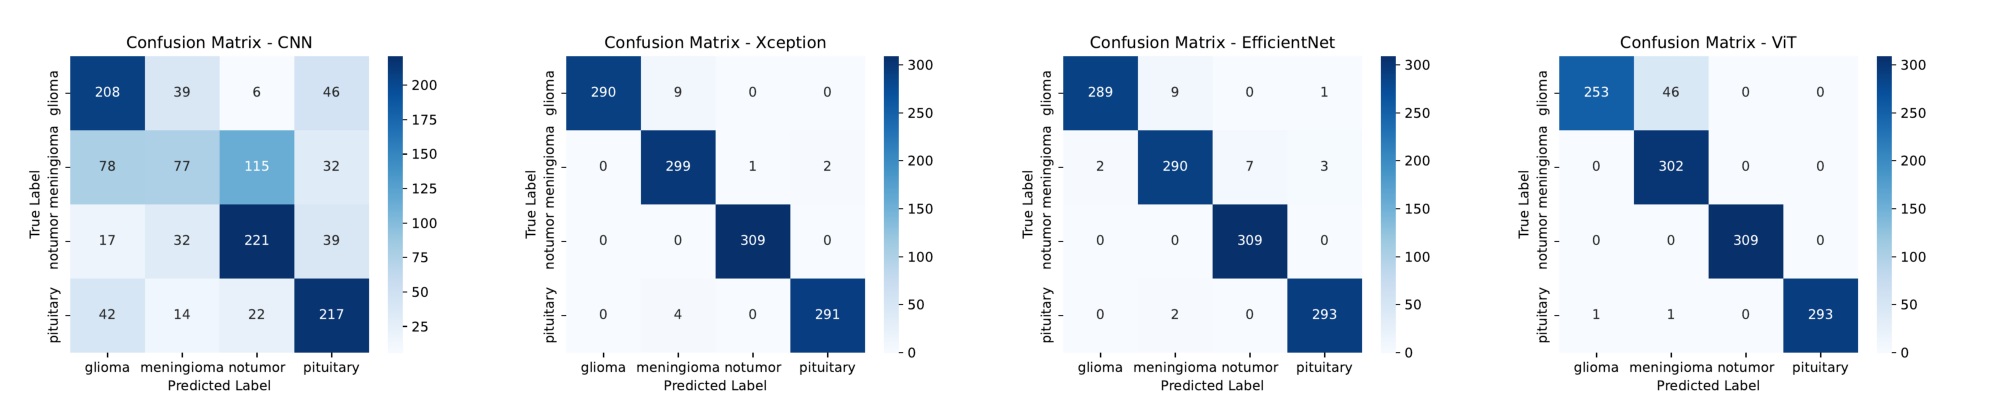

Combined confusion matrix PDF saved as: /content/drive/MyDrive/UE/BrainTumorDetection/RQ3/RQ3_All_Confusion_Matrices.pdf


In [ ]:
# !apt-get install -y poppler-utils
model_files = {
    'CNN':            'CNN_metrics.json',
    'XceptionNet':    'Xception_metrics.json',
    'EfficientNet-B0':'EfficientNet_metrics.json',
    'ViT':            'ViT_metrics.json'
}

base_dir = '/content/drive/MyDrive/UE/BrainTumorDetection'

# Extract classwise metrics and save as Excel
results = []

for model, fname in model_files.items():
    fpath = os.path.join(base_dir, fname)
    if not os.path.exists(fpath):
        print(f"File not found: {fpath}")
        continue
    with open(fpath, 'r') as f:
        data = json.load(f)
        for cls in data:
            if cls in ['accuracy', 'macro avg', 'weighted avg']:
                continue
            cls_metric = data[cls]
            results.append({
                'Model': model,
                'Class': cls,
                'Precision': cls_metric.get('precision', 0),
                'Recall': cls_metric.get('recall', 0),
                'F1-Score': cls_metric.get('f1-score', 0),
                'Support': cls_metric.get('support', 0)
            })

df = pd.DataFrame(results)
df = df.sort_values(by=['Model', 'Class']).reset_index(drop=True)

display(df)

save_path = os.path.join(base_dir, 'RQ3/RQ3_classwise_metrics_by_model.xlsx')
df.to_excel(save_path, index=False)
print(f"Excel file saved as '{save_path}'")

# ---- Combine Confusion Matrix PDFs ----

conf_matrix_files = [
    os.path.join(base_dir, 'Confusion_Matrix/CNN_Confusion_Matrix.pdf'),
    os.path.join(base_dir, 'Confusion_Matrix/Xception_Confusion_Matrix.pdf'),
    os.path.join(base_dir, 'Confusion_Matrix/EfficientNet_Confusion_Matrix.pdf'),
    os.path.join(base_dir, 'Confusion_Matrix/ViT_Confusion_Matrix.pdf')
]
model_names = ['CNN', 'XceptionNet', 'EfficientNet-B0', 'ViT']

# Convert each PDF's first page to image
imgs = []
for pdf_file in conf_matrix_files:
    if not os.path.exists(pdf_file):
        print(f"Confusion matrix file not found: {pdf_file}")
        imgs.append(None)
        continue
    # Convert first page of PDF to PIL image
    img = convert_from_path(pdf_file, first_page=1, last_page=1)[0]
    imgs.append(img)

# Plot all images in one row (ignore missing)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (img, ax, name) in enumerate(zip(imgs, axes, model_names)):
    if img is not None:
        ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Save combined figure as PDF
combined_pdf_path = os.path.join(base_dir, 'RQ3/RQ3_All_Confusion_Matrices.pdf')
fig.savefig(combined_pdf_path, bbox_inches='tight')
print(f"Combined confusion matrix PDF saved as: {combined_pdf_path}")


# RQ4: Training Dynamics
*How does the accuracy of the basic CNN model change as the number of training epochs increases (in steps of 10 up to 100), and what can we learn from this trend about the training needs of a simple CNN for brain tumor detection?*

In [ ]:
# Please refer to the results above (11-1, 11-2)

# RQ5: eXplainable AI (Grad-CAM Visualization)
*What insights can be gained from Grad-CAM visualizations about the decision-making process of each CNN-based model for brain tumor detection?*

In [ ]:
# Please refer to the results above (16)

# For Reference Only: Extract data to include in the paper

In [ ]:
import os
import json
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/UE/BrainTumorDetection'
csv_dir = os.path.join(base_dir, 'CSV')
os.makedirs(csv_dir, exist_ok=True)

model_files = {
    'CNN':            'CNN_metrics.json',
    'XceptionNet':    'Xception_metrics.json',
    'EfficientNet-B0':'EfficientNet_metrics.json',
    'ViT':            'ViT_metrics.json'
}

results = []

for model_name, file_name in model_files.items():
    file_path = os.path.join(base_dir, file_name)
    with open(file_path, 'r') as f:
        metrics = json.load(f)

    # Extract from your json structure
    row = {
        'Model': model_name,
        'Accuracy': round(metrics.get('accuracy', 0), 4),
        'Precision (Weighted)': round(metrics['weighted avg']['precision'], 4),
        'Recall (Weighted)': round(metrics['weighted avg']['recall'], 4),
        'F1-score (Weighted)': round(metrics['weighted avg']['f1-score'], 4),
        'Precision (Macro)': round(metrics['macro avg']['precision'], 4),
        'Recall (Macro)': round(metrics['macro avg']['recall'], 4),
        'F1-score (Macro)': round(metrics['macro avg']['f1-score'], 4)
    }
    results.append(row)

df = pd.DataFrame(results)
display(df)

csv_path = os.path.join(csv_dir, 'model_performance_summary.csv')
df.to_csv(csv_path, index=False)



Mounted at /content/drive


,Model,Accuracy,Precision (Weighted),Recall (Weighted),F1-score (Weighted),Precision (Macro),Recall (Macro),F1-score (Macro)
0,CNN,0.6000,0.5835,0.6000,0.5808,0.5838,0.6004,0.5812
1,XceptionNet,0.9867,0.9871,0.9867,0.9868,0.9871,0.9866,0.9867
2,EfficientNet-B0,0.9801,0.9802,0.9801,0.9800,0.9802,0.9800,0.9800
3,ViT,0.9602,0.9653,0.9602,0.9600,0.9653,0.9598,0.9599
